In [1]:
from j2v import mag
from j2v import w2v
from j2v import predict

import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
%matplotlib inline

Using Theano backend.


In [2]:
model = w2v.load_j2v(mag.DATA_ROOT+'/100feat_50minwords_10context_2016')


model shape is: (20835, 100) 



In [3]:
mapping = mag.load_map_jid_discipline('journal_discipline_map.csv')
mapping = mapping[mapping['disc_name'] != 'Interdiscipline']
mapping.index = range(len(mapping))

14113 journals in MAG's Journal.txt were matched to UCSD data, and 29 of them are interdisciplinary journals in UCSD catelog.


In [4]:
vname_vid = mag.get_venue_dict(key = 'name')
vid_vname = {vid: vname for vname, vid in vname_vid.items()}

processing /l/nx/data/haopeng/j2v/Journals.txt...
finished processing!

processing /l/nx/data/haopeng/j2v/Conferences.txt...
finished processing!



### soft-hard

In [7]:
disc_domain = {'Math & Physics': 'Mathematical', 'Social Sciences': 'Social', 'Humanities': 'Social'}

In [9]:
def get_direction(model, mapping):
    '''e.g. get direction vector from social center point to mathematical center point.'''
    vid2index = dict((vid, i) for i, vid in enumerate(model.index2word))
    s_ix, n_ix = [], []
    for i in range(len(mapping)):
        jid, disc_name = mapping.iloc[i][['jid', 'disc_name']]
        if disc_name in disc_domain:
            if jid in vid2index:
                ind = vid2index[jid]
                if disc_domain[disc_name] == 'Mathematical':
                    n_ix.append(ind)
                else: s_ix.append(ind)
    math_vec = np.mean(model.syn0[n_ix, :].astype('float64'), axis = 0)
    social_vec = np.mean(model.syn0[s_ix, :].astype('float64'), axis = 0)
    math_vec = math_vec / np.linalg.norm(math_vec)
    social_vec = social_vec / np.linalg.norm(social_vec)
    social2math = math_vec - social_vec
    # it doesn't matter normalize the direction or not.
    # social2natural = social2natural / np.linalg.norm(social2natural)
    return social2math

In [10]:
direction = get_direction(model, mapping)

In [11]:
print(list(w2v.dis2color.keys()))

['Brain Research', 'Medical Specialties', 'Health Professionals', 'Social Sciences', 'Earth Sciences', 'Biology', 'Chemical, Mechanical, & Civil Engineering', 'Chemistry', 'Biotechnology', 'Infectious Diseases', 'Math & Physics', 'Humanities', 'Electrical Engineering & Computer Science', 'Interdiscipline']


In [18]:
target = 'Social Sciences'
# target = 'Electrical Engineering & Computer Science'
# target = 'Brain Research'
# target = 'Biology'
# target = 'Math & Physics'
top = 30

In [19]:
sub_data = defaultdict(list)
for i in range(len(mapping)):
    jid, sub, dis = mapping.loc[i, ['jid', 'subd_name', 'disc_name']].tolist()
    if jid in model and dis == target:
        sub_data[sub].append(jid)

In [20]:
sub_data_ = list(sorted(sub_data.items(), key = lambda x: len(x[1])))[-top:]

In [21]:
for s in sub_data_:
    print(s[0], len(s[1]))

Operations Management 36
Leadership & Organizational Behavior 36
Pyschiatric & Behavioral Genetics 37
Sociology 38
Operations Research 39
Statistics 40
Research Policy; Technology Management 42
Environmental Policy 42
International Conflict 43
Teacher Education; Evaluation 43
Tourism 45
Communication Research 46
Pragmatics & Discourse 47
Ethnology 48
Regional Studies 49
Language Learning 51
Decision Support Systems 52
Law 53
Education 55
Social Psychology 55
Business Ethics 56
Engineering Education 71
Finance 76
Economics 81
Econometrics 81
Public Policy 87
Strategic Management 90
Educational Psychology 96
Marital & Family Therapy 109
Human Resource Management 169


In [22]:
sub_cosine = defaultdict(list)
for sub, jids in sub_data_:
    for jid in jids:
        sub_cosine[sub].append(1 - cosine(direction, model[jid]))

In [23]:
def plot_box(ax):
    # plot left, right and top border line.
    ax.plot((-0.6, 0.6), (0.1, 0.1), color = 'k')
    ax.plot((-0.6, -0.6), (-0.1, 0.1), color = 'k')
    ax.plot((0.6, 0.6), (-0.1, 0.1), color = 'k')
    ax.plot((-0.6, 0.6), (-0.1, -0.1), color = 'k')

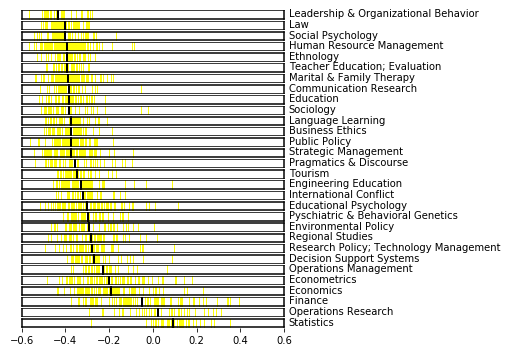

In [24]:
fig = plt.figure(figsize=(4.5, 5))
sub_cosine_ = list(sorted(sub_cosine.items(), key = lambda x: np.mean(x[1])))

# create axes
axes = []
num = len(sub_cosine_)
for i in range(num):
    axes.append(plt.subplot2grid((num,1), (i, 0), rowspan=1, colspan=1))

hex_c = w2v.color2hex[w2v.dis2color[target]]
for i in range(num):
    sub, cosine_list = sub_cosine_[i]
    axes[i].set_xlim(-0.65, 0.7)
    axes[i].set_ylim(-0.11, 0.11)
    for cos in cosine_list:
        axes[i].plot((cos, cos), (-0.1, 0.1), color = hex_c, linewidth = 1)
    axes[i].plot((np.mean(cosine_list), np.mean(cosine_list)), (-0.1, 0.1), color = 'k', linewidth = 2)
    plot_box(axes[i])
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].yaxis.set_ticks([])
    if i != num-1:
        axes[i].xaxis.set_ticks([])
    else: axes[i].xaxis.set_ticks_position('bottom')
    axes[i].text(0.62, -0.04, sub, fontsize = 13 - top/10)

fig.tight_layout()
fig.subplots_adjust(hspace = 0.1)
plt.show()
fig.savefig("spectrum-%s-%d.pdf"%(target.lower().split()[0], top), bbox_inches='tight', pad_inches=0, dpi = 300)

### social-bio

In [5]:
domain = {'biological science': 
              ['Medical Specialties', 'Health Professionals', 'Biology', 'Biotechnology', 'Infectious Diseases'],
 'social science': ['Social Sciences', 'Humanities']}

In [6]:
def get_direction(model, mapping, domain):
    disc_domain = {}
    for d, li in domain.items():
        for l in li:
            disc_domain[l] = d
    vid2index = dict((vid, i) for i, vid in enumerate(model.index2word))
    s_ix, n_ix = [], []
    for i in range(len(mapping)):
        jid, disc_name = mapping.iloc[i][['jid', 'disc_name']]
        if jid in vid2index and disc_name in disc_domain:
            ind = vid2index[jid]
            if disc_domain[disc_name] != 'social science':
                n_ix.append(ind)
            else: s_ix.append(ind)
    natural_vec = np.mean(model.syn0[n_ix, :].astype('float64'), axis = 0)
    social_vec = np.mean(model.syn0[s_ix, :].astype('float64'), axis = 0)
    natural_vec = natural_vec / np.linalg.norm(natural_vec)
    social_vec = social_vec / np.linalg.norm(social_vec)
    social2natural = natural_vec - social_vec
    # it doesn't matter normalize the direction or not.
    # social2natural = social2natural / np.linalg.norm(social2natural)
    return social2natural

In [7]:
direction = get_direction(model, mapping, domain)

In [15]:
target = 'Social Sciences'
# target = 'Electrical Engineering & Computer Science'
# target = 'Brain Research'
# target = 'Biology'
top = 30

In [16]:
sub_data = defaultdict(list)
for i in range(len(mapping)):
    jid, sub, dis = mapping.loc[i, ['jid', 'subd_name', 'disc_name']].tolist()
    if jid in model and dis == target:
        sub_data[sub].append(jid)

In [17]:
sub_data_ = list(sorted(sub_data.items(), key = lambda x: len(x[1])))[-top:]

In [18]:
for s in sub_data_:
    print(s[0], len(s[1]))

Operations Management 36
Leadership & Organizational Behavior 36
Pyschiatric & Behavioral Genetics 37
Sociology 38
Operations Research 39
Statistics 40
Research Policy; Technology Management 42
Environmental Policy 42
International Conflict 43
Teacher Education; Evaluation 43
Tourism 45
Communication Research 46
Pragmatics & Discourse 47
Ethnology 48
Regional Studies 49
Language Learning 51
Decision Support Systems 52
Law 53
Education 55
Social Psychology 55
Business Ethics 56
Engineering Education 71
Finance 76
Economics 81
Econometrics 81
Public Policy 87
Strategic Management 90
Educational Psychology 96
Marital & Family Therapy 109
Human Resource Management 169


In [19]:
sub_cosine = defaultdict(list)
for sub, jids in sub_data_:
    for jid in jids:
        sub_cosine[sub].append(1 - cosine(direction, model[jid]))

In [20]:
def plot_box(ax):
    # plot left, right and top border line.
    ax.plot((-0.6, 0.6), (0.1, 0.1), color = 'k')
    ax.plot((-0.6, -0.6), (-0.1, 0.1), color = 'k')
    ax.plot((0.6, 0.6), (-0.1, 0.1), color = 'k')
    ax.plot((-0.6, 0.6), (-0.1, -0.1), color = 'k')

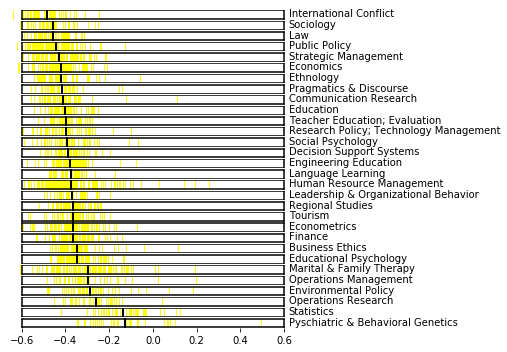

In [21]:
fig = plt.figure(figsize=(4.5, 5))
sub_cosine_ = list(sorted(sub_cosine.items(), key = lambda x: np.mean(x[1])))

# create axes
axes = []
num = len(sub_cosine_)
for i in range(num):
    axes.append(plt.subplot2grid((num,1), (i, 0), rowspan=1, colspan=1))

hex_c = w2v.color2hex[w2v.dis2color[target]]
for i in range(num):
    sub, cosine_list = sub_cosine_[i]
    axes[i].set_xlim(-0.65, 0.7)
    axes[i].set_ylim(-0.11, 0.11)
    for cos in cosine_list:
        axes[i].plot((cos, cos), (-0.1, 0.1), color = hex_c, linewidth = 1)
    axes[i].plot((np.mean(cosine_list), np.mean(cosine_list)), (-0.1, 0.1), color = 'k', linewidth = 2)
    plot_box(axes[i])
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].yaxis.set_ticks([])
    if i != num-1:
        axes[i].xaxis.set_ticks([])
    else: axes[i].xaxis.set_ticks_position('bottom')
    axes[i].text(0.62, -0.04, sub, fontsize = 13 - top/10)

fig.tight_layout()
fig.subplots_adjust(hspace = 0.1)
plt.show()
fig.savefig("spectrum-%s-%d.pdf"%(target.lower().split()[0], top), bbox_inches='tight', pad_inches=0, dpi = 300)

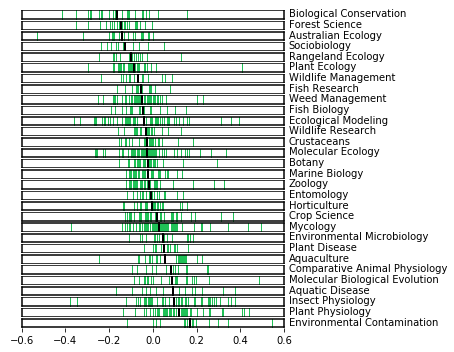

In [14]:
fig = plt.figure(figsize=(4.5, 5))
sub_cosine_ = list(sorted(sub_cosine.items(), key = lambda x: np.mean(x[1])))

# create axes
axes = []
num = len(sub_cosine_)
for i in range(num):
    axes.append(plt.subplot2grid((num,1), (i, 0), rowspan=1, colspan=1))

hex_c = w2v.color2hex[w2v.dis2color[target]]
for i in range(num):
    sub, cosine_list = sub_cosine_[i]
    axes[i].set_xlim(-0.65, 0.7)
    axes[i].set_ylim(-0.11, 0.11)
    for cos in cosine_list:
        axes[i].plot((cos, cos), (-0.1, 0.1), color = hex_c, linewidth = 1)
    axes[i].plot((np.mean(cosine_list), np.mean(cosine_list)), (-0.1, 0.1), color = 'k', linewidth = 2)
    plot_box(axes[i])
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].yaxis.set_ticks([])
    if i != num-1:
        axes[i].xaxis.set_ticks([])
    else: axes[i].xaxis.set_ticks_position('bottom')
    axes[i].text(0.62, -0.04, sub, fontsize = 13 - top/10)

fig.tight_layout()
fig.subplots_adjust(hspace = 0.1)
plt.show()
fig.savefig("spectrum-%s-%d.pdf"%(target.lower().split()[0], top), bbox_inches='tight', pad_inches=0, dpi = 300)